In [415]:
import numpy as np
import cv2
import cv2.ximgproc as cvx
import matplotlib.pyplot as plt
from domain_transform import DomainTransform
from skimage.io import imread
import scipy.stats as st


dt = DomainTransform()

In [1330]:
lmbd = 0.99

In [1332]:
def derivative(zi, confidence, target, reference, lmbd):
    return lmbd*(zi - reference) + confidence*(zi - target)

In [1333]:
def cost(zi, confidence, target, reference, lmdb):
    cost_matrix1 = np.power(zi - reference, 2)
    cost_matrix2 = confidence*np.power(zi - target, 2)
    sum1 = (lmbd/2)*np.sum(np.sum(cost_matrix1, axis=0), axis=0)
    sum2 = np.sum(np.sum(cost_matrix2, axis=0), axis=0)
    return sum1 + sum2

In [1361]:
reference = imread('depth_superres/reference.png') / 255.0
#reference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)/ 255.0
target = imread('depth_superres/target.png')
confidence = imread('depth_superres/confidence.png')
gt = imread('depth_superres/ground_truth.png')

In [1435]:
# Used to build the bump model
'''def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw#/kernel_raw.sum()
    return kernel   

def generate_bump(image, size, sigma):
    x = gkern(size, sigma)
    y = gkern(size, sigma)
    bump = x*y.T
    bump = bump/np.max(bump)
    bump_image = np.tile(bump, (int(image.shape[0]/size), int(image.shape[1]/size)))
    return bump_image'''

'def gkern(kernlen=21, nsig=3):\n    """Returns a 2D Gaussian kernel array."""\n\n    interval = (2*nsig+1.)/(kernlen)\n    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)\n    kern1d = np.diff(st.norm.cdf(x))\n    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))\n    kernel = kernel_raw#/kernel_raw.sum()\n    return kernel   \n\ndef generate_bump(image, size, sigma):\n    x = gkern(size, sigma)\n    y = gkern(size, sigma)\n    bump = x*y.T\n    bump = bump/np.max(bump)\n    bump_image = np.tile(bump, (int(image.shape[0]/size), int(image.shape[1]/size)))\n    return bump_image'

In [1417]:
# USsed for other inputs
'''reference = imread('art_big/view1.png')
reference = cv2.resize(reference, (1376, 1088))
reference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)/255.0
target = imread('art_big/depth_4_n.png')/255
target = cv2.resize(target, (1376, 1088), interpolation=cv2.INTER_CUBIC)
confidence = generate_bump(target, 16, 2)
gt = imread('depth_superres/ground_truth.png')'''

"reference = imread('art_big/view1.png')\nreference = cv2.resize(reference, (1376, 1088))\nreference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)/255.0\ntarget = imread('art_big/depth_4_n.png')/255\ntarget = cv2.resize(target, (1376, 1088), interpolation=cv2.INTER_CUBIC)\nconfidence = generate_bump(target, 16, 2)\ngt = imread('depth_superres/ground_truth.png')"

Convert to domain [0,1] as bilateral solver example

In [1367]:
filtered_target[0,0]

0.32321006

In [1364]:
t = target.astype(np.double)/(pow(2,16)-1)
c = confidence.astype(np.double)/(pow(2,16)-1)
reference = reference.astype(np.float32)
t = t.astype(np.float32)
c = c.astype(np.float32)

In [1340]:
reference = reference.astype(np.float32)
t = target.astype(np.float32)
c = confidence.astype(np.float32)

Joint filtering the target map using the reference as parameter(The same way described in the DT paper).
This is equivalent to equation (10) in DTSolver

In [1366]:
#filtered_target = dt.normalized_convolution(t, 200, 0.55, 3, reference)
filtered_target = cvx.dtFilter(reference, t, 1200, 0.1, mode=cvx.DTF_NC, numIters=3)

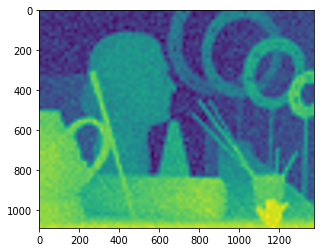

In [1342]:
plt.imshow(target)

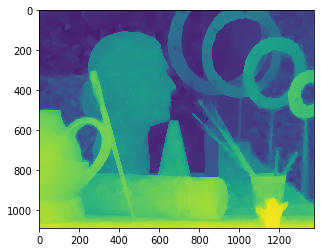

In [1241]:
plt.imshow(filtered_target)

### Sample of one iteration 

In [1355]:
zi = t

In [1370]:
cost1 = cost(zi, c, t, filtered_target, lmbd)
cost1

137.67388412475586

Derivative

In [1371]:
der = derivative(zi, c, t, filtered_target,lmbd)

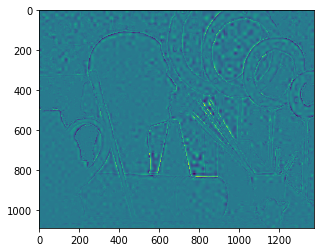

In [1373]:
plt.imshow(der)

First gradient descent iteration

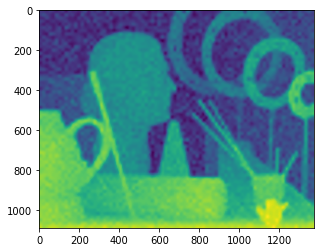

In [1374]:
zi = zi - 0.2*der
plt.imshow(zi)

Second iteration

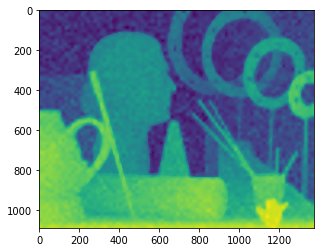

In [1378]:
der = derivative(zi, c, t, filtered_target,lmbd)
zi = zi - 0.2*der
plt.imshow(zi)

# # Calculate root mean square error after multiple iterations

In [1418]:
lmbd = 0.99
sigma_s = 32

def solve(zi=None,c=None,t=None,reference=None, lmbd=None):
    r = zi
    zn = cvx.dtFilter(reference, t, sigma_s, 0.25, mode=cvx.DTF_NC, numIters=3)
    for i in range(0, 10):
        der = derivative(r, c, t, zn,lmbd)
        r = r - 0.99*der
        zn = cvx.dtFilter(reference, r, sigma_s, 0.25, mode=cvx.DTF_NC, numIters=3)
       
    return r

In [1419]:
result = solve(t, c, t, filtered_target, 0.99)

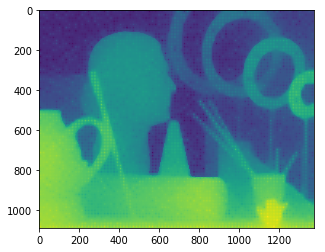

In [1420]:
plt.imshow(result)

In [1421]:
def rms(gt, test):
    total = gt.shape[0] * gt.shape[1]
    sq_diff = np.power((gt - test), 2)
    summed = np.sum(np.sum(sq_diff))
    return np.sqrt(summed/total)

In [1429]:
rms(gt, result*255)

11.767766333077159

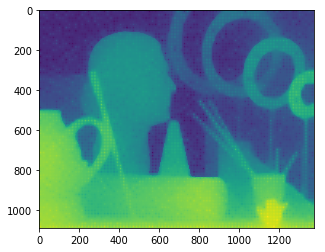

In [1430]:
plt.imshow(result)

In [1434]:
cv2.imwrite("result.png", result)

True